# Demonstration for pyIsofit
#### _Updated 25.08.2021_
***

Importing the package and `pandas`:

In [26]:
from pyIsoFit import IsothermFit
import pandas as pd

### 1. Fitting any model for a single dataframe
***

To fit data first create a `pandas` Dataframe variable using `pd.read_csv()` (or json). The file must contain all datasets to be fitted (any number of datasets), with unique keys for each pressure and uptake:
    
i.e the key is the column header for the pressure of the first dataset is 'p@0C', for the second dataset it's 'p@20C' ect.

The datasets used in this example are computational data from EPFL for CO₂ and N₂ on Zeolite 13X.

In [27]:
df1 = pd.read_csv('../tests/Datasets for testing/Computational Data (EPFL) CO2.csv')

Next, define a list of integers (or floats) which include the temperatures of each dataset. We can input either degrees C or K - the default is C and so we do not have to specify the units. If we wanted to input temperature in Kelvin we would pass the `temp_units='K'` kwarg when we create the class instance. 

    temps = [0, 20, ...]

In [28]:
temps = [10, 40, 100]

Next, define the keys for the package to extract the data. This requires a list of strings.

    i.e key_pressures = ['p@0C', 'p@20C', '...']
        key_uptakes = ['q@0C', 'q@20C', '...']

In the example below, the pressure values corresponding to each uptake value for every dataset are identical, thus we pass the same string for all three datasets within `key_pressures`. 

In [29]:
key_pressures = ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)']
key_uptakes = ['Uptake (mmol/g)_13X_10 (°C)', 'Uptake (mmol/g)_13X_40 (°C)', 'Uptake (mmol/g)_13X_100 (°C)']

To fit this data to a model, create an instance of the `IsothermFit` class. This requires the user choosing a model from
the following list:

    i.e ['henry', 'mdr', 'langmuir', 'langmuir linear 1', 'langmuir linear 2', 'langmuir td',
        'dsl', 'gab', 'sips', 'toth', 'bddt', 'bddt 2n', 'bddt 2n-1',
        'dodo', 'bet']

Notes:
      
- '`td`' means temperature dependent - i.e equilibrium constant is temperature dependent { b = b0 * exp(-H/RT) }
- '`langmuir linear 1`' is using the linear form of langmuir with axis 1/q vs. 1/p
- '`langmuir linear 2`' is using the linear form of langmuir with axis p/q vs. p
- There are two forms of the bddt isotherm, both with the same parameters. One is for an n (layers) of 2n, and the other is for a n (layers) of 2n-1. Choosing '`bddt`' will fit to the '`bddt 2n`' isotherm model.
- High parameter models may require custom guess values to work - further discussed below.
- Inputting a list of dataframes is only supported for the 'dsl' fitting procedure - further discussed below

The class is called in the following way - the component name can also passed as a kwarg (not passing this would result in an arbitrary letter being allocated to the component):

In [30]:
test = IsothermFit(df1, temps, key_pressures, key_uptakes, 'langmuir', compname='CO2')

To fit the model using default settings, call the `.fit()` method on the test object as follows:

In [31]:
test.fit()




---- Component CO2 fitting results -----


,T (K),q (mmol/g),b (1/bar),MSE
0,283,6.617386,39.990815,0.242401
1,313,6.274611,9.214582,0.088254
2,373,5.373004,1.492227,0.013726


_______________________________________________________________________
Heat of adsorption for site A:-31.85 kJ/mol. 
R sq of Van't Hoff: 0.9984


Where MSE is the mean squared error of the fitting

### 2. The `.fit()` and `.plot()` methods
***

The following are parameter definitions for this method:

#### :param `cond` : bool
Input whether to add standardised fitting constraints to fitting procedure. These are different
for each fitting. Currently only works for `Langmuir`, `Langmuir td`, `DSL`, `BDDT`. Default is `False`

#### :param `meth `: str
Input the fitting algorithm which `lmfit` uses to fit curves. Default is `'leastsq'` however `lmfit` includes
many fitting algorithms which can be inputted (https://lmfit.github.io/lmfit-py/fitting.html).

#### :param `show_hen` : bool
Input whether to show the henry regime of the datasets approximated by the package. This is `False` by
default.

#### :param `hen_tol`: float or list[float]
The henry region approximation function calculates the henry region by finding a line with the highest
R squared value in the low pressure region of the dataset. This is done with a default R squared
tolerance value (set to 0.999).
For example, if a float is inputted (a different henry tolerance) this will be the henry tolerance value
used by the function. i.e if 0.98 is inputted the henry regime will be across a large pressure range
due to the low tolerance for the R squared value of the henry model fitting.
This function also supports inputting the henry regimes manually. For this, input each henry regime for
each dataset as a list i.e `[1.2, 2.1, ... ]`

#### :param `rel_pres` : bool
Input whether to fit the x axis data to relative pressure instead of absolute. Default is `False`

#### :param `henry_off` : bool
Input whether to turn off the henry regime fitting constraint when using the standardised fitting 
constraint to `langmuir` or `dsl` - this is usually done when fitting experimental data which has a messy
low pressure region. Default is `False`.

#### :param `guess` : dict
Input custom guess values to override the default guess values. This must be inputted as a dictionary
with the keys corresponding to the parameter string and the value corresponding to the list of guess
values corresponding to each dataset.
i.e for `Langmuir`: `guess = {'q': [5, 5, 6], 'b':[100, 1000, 2000]}`

#### :param `cust_bounds` : dict
Input custom bounds for the fitting. These are hard constraints and lmfit will fit only within these 
minimum and maximum values. Input these as a dictionary with the keys corresponding to the parameter
string and the value corresponding to the list of tuples which include bounds for each dataset in the 
format (`min, max`).
i.e for `Langmuir`: `cust_bounds = {'q': [(4,6), (4, None), (5,10)], ... ect.}`
NOTE: constrained DSL fitting does not support custom bounds

#### :param `fit_report` : bool
Display a fitting report generated by lmfit for each dataset. Default is `False`

***
Important Note! heat of adsorption will not be calculated unless 3 or more datasets at different temperatures for the same component are imported.


***
In the example below, we can fix qsat for all temperatures (kwarg `cond=True`) and constrain parameter 'b' to the expression KH = b * q. To display henry we pass `show_hen=True` as a kwarg.

In [32]:
test.fit(cond=True, show_hen=True)


Henry regime for component CO2:


,Henry constant (mmol/(bar.g)),Upper limit (bar),datapoints,R squared
0,1234.382935,0.0002,3,0.99981
1,172.973392,0.0010,6,0.99958
2,11.306467,0.0007,5,0.99903


 Henry region tolerance may be entered as a kwarg - either as a float (default = 0.999) or a list of floats specifying the upper limit for the henry regime for each dataset.






---- Component CO2 fitting results -----


,T (K),q (mmol/g),b (1/bar),MSE
0,283,6.230304,198.125631,0.571425
1,313,6.230304,27.763234,0.552249
2,373,6.230304,1.814754,0.422753


_______________________________________________________________________
Heat of adsorption for site A:-45.63 kJ/mol. 
R sq of Van't Hoff: 0.9997


To see the plot of this we call the `.plot()` method. The plot method has one optional argument, logplot. This sets the x and y axis to a log scale. If we wanted to set the x axis to a log scale but y normal, we would enter the logplot toggle as a tuple of the shape (`xscale, yscale`). Since we are interested in the low pressure region here, we will pass `logplot=True` as an argument.

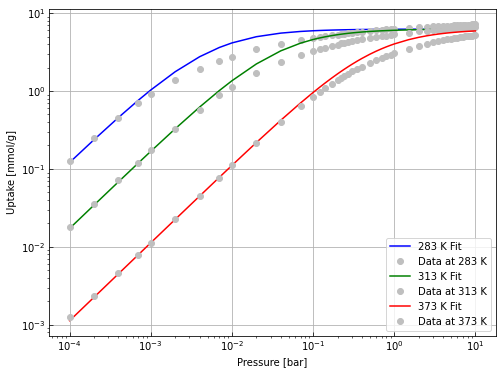

In [33]:
test.plot(logplot=True)

As expected due to the henry regime constraint, the model fits well in the low pressure region but fails in the high pressure region. We can try this dataset with the dual site Langmuir (`DSL`) isotherm model fitting with and without constraints as Zeolite 13X is known to fit well to DSL. We already know the henry regime of this dataset so we will not display it.

In [34]:
test = IsothermFit(df1, temps, key_pressures, key_uptakes, 'dsl', compname='CO2')
test.fit()




---- Component CO2 fitting results -----


,T (K),q1 (mmol/g),q2 (mmol/g),b1 (1/bar),b2 (1/bar),MSE
0,283,2.764013,4.393399,2.589032,189.718415,0.009321
1,313,2.830555,3.895321,1.175446,35.804262,0.002105
2,373,2.956216,3.091044,0.304448,3.241951,0.000124


_______________________________________________________________________
Heat of adsorption for site A:-20.95 kJ/mol. 
R sq of Van't Hoff: 0.9995
_______________________________________________________________________
Heat of adsorption for site B:-39.61 kJ/mol. 
R sq of Van't Hoff: 0.9999


Now for the constrained fitting:

In [35]:
test = IsothermFit(df1, temps, key_pressures, key_uptakes, 'dsl', compname='CO2')
test.fit(cond=True)

CRITICAL:pyIsoFit-master:The model function generated NaN values and the fit aborted!Please check your model function and/or set boundaries on parameters where applicableIn these cases try changing lmfit fitting method (default is "leastsq") to "tnc"


_________________________CO2 RESULTS_____________________________
 


UnboundLocalError: local variable 'dsl_result' referenced before assignment

__We have encountered an error!__ - it looks like `'leastsq'`, which is `scipy.optimize.leastsq`, doesn't work very well for this particular dataset - perhaps changing the guess values or the fitting algorithm will help. For this, `meth='tnc'` will be passed as a kwarg.

In [36]:
test = IsothermFit(df1, temps, key_pressures, key_uptakes, 'dsl', compname='CO2')
test.fit(cond=True, meth='tnc');

_________________________CO2 RESULTS_____________________________
 

Parameters found...


,Temp(K),qmax1 (mmol/g),qmax2 (mmol/g),h1 (J/mol),h2 (J/mol),b01 (1/bar),b02 (1/bar),mse
0,283,3.731195,3.351731,-45822.537149,-36142.880987,9.665755e-07,9.298407e-07,0.012951
1,313,3.731195,3.351731,-45822.002733,-36142.745811,1.000664e-06,8.154136e-07,0.018459
2,373,3.731195,3.351731,-45822.736145,-36143.217520,1.045907e-06,9.270611e-07,0.001504


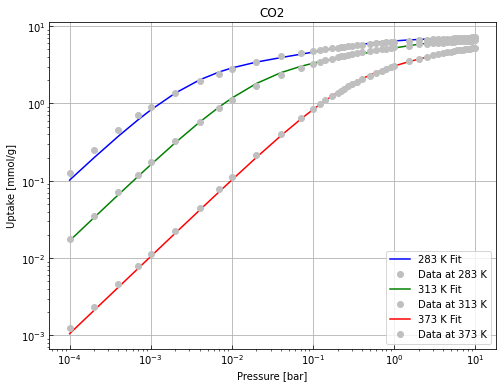

In [37]:
test.plot(logplot=True)

The constrained fitting procedure is based on thermodynamic consistency fitting requirements described by [Talu and Myers (1988)](https://aiche.onlinelibrary.wiley.com/doi/epdf/10.1002/aic.690341114).
[Farmahini et al. (2018)](https://doi.org/10.1021/acs.iecr.8b03065) described several thermodynamically consistent fitting procedures which follow Talu and Myers requirements and provide constraints to aid fitting, which they used to fit the DSL isotherm model to pure-component GCMC isotherm data for CO₂ and N₂ on Zeolite 13X. They used the results from this method to predict binary co-adsorption isotherms. 

`pyIsoFit`'s DSL fitting procedure is based on this. This is a multi step procedure where in the final step the most adsorbed component is fit to the temperature dependent form of the DSL isotherm model and the rest of the other components are fit to the temperature dependent form of the single site Langmuir isotherm model.

Note: 
Because the dsl constrained fitting procedure contains multiple steps for more than one components, custom bounds for this model are a work in progress and do not currently work.


### 3. The `.plot_emod()` method
***
We can also use the DSL fitting procedure to predict multicomponent adsorption for any number of components. 

To start off, we import another set of datasets for Nitrogen. The keys for pressure and uptakes must be the same for both component datasets. We create an instance of the class by importing the dataframes and component names (optional) as lists.

The `temps`, `key_pressures` and `key_uptakes` variables will be re-used as they are the same for this example.

In [38]:
df2 = pd.read_csv('../tests/Datasets for testing/Computational Data (EPFL) N2.csv')
df_list = [df1, df2]
compnames = ['CO2', 'N2']

test = IsothermFit(df_list, temps, key_pressures, key_uptakes, 'dsl', compname=compnames)

Now running the `.fit()` method with cond=True and show_henry=True

In [40]:
test.fit(cond=True, show_hen=True, meth='tnc', henry_off=True)
test.plot(logplot=True)


Henry regime for component CO2:


,Henry constant (mmol/(bar.g)),Upper limit (bar),datapoints,R squared
0,1234.382935,0.0002,3,0.99981
1,172.973392,0.0010,6,0.99958
2,11.306467,0.0007,5,0.99903


 Henry region tolerance may be entered as a kwarg - either as a float (default = 0.999) or a list of floats specifying the upper limit for the henry regime for each dataset.




Henry regime for component N2:


,Henry constant (mmol/(bar.g)),Upper limit (bar),datapoints,R squared
0,0.326919,0.7,27,0.99916
1,0.170289,1.5,31,0.99909
2,0.064547,5.5,39,0.99908


CO2 was found to have the highest qsat(total) This will be used as component A. 
CO2 shows a qsat(total) of 7.2 mmol/g
_________________________CO2 RESULTS_____________________________
 

Parameters found...


,Temp(K),qmax1 (mmol/g),qmax2 (mmol/g),h1 (J/mol),h2 (J/mol),b01 (1/bar),b02 (1/bar),mse
0,283,2.759252,4.398968,-84170.300857,-13715.242644,1.334488e-13,0.030036,0.086779
1,313,2.759252,4.398968,-84129.405524,-13952.299986,1.532108e-14,0.038433,0.257531
2,373,2.759252,4.398968,-84128.296850,-13954.988541,9.947598e-14,0.023350,0.001722


CRITICAL:pyIsoFit-master:The model function generated NaN values and the fit aborted!Please check your model function and/or set boundaries on parameters where applicableIn these cases try changing lmfit fitting method (default is "leastsq") to "tnc"


_________________________N2 RESULTS_____________________________
 


UnboundLocalError: local variable 'dsl_result' referenced before assignment

Now that we have fittings for CO₂ and N₂, we can predict co-adsorption using `.plot_emod()`. This requires knowledge of the mole fractions of each component in the mixture - this is inputted as a list. Currently the only supported extended model is the 'extended dsl' model so the ext_model parameter can be ignored.

The ';' is to hide the cell output witin JN however `.plot_emod()` returns a dictionary of the co-adsorption uptake results for each dataset.

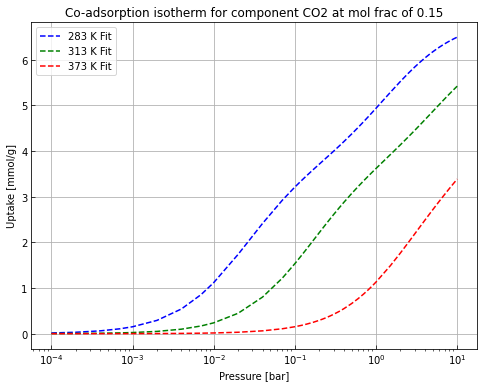

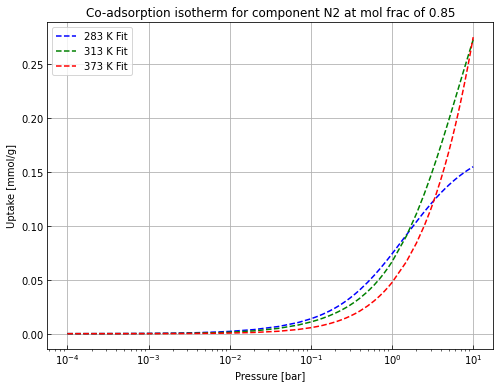

In [15]:
test.plot_emod(logplot=(True, False), yfracs=[0.15, 0.85]);

### 4. the .save() method
***
This simply saves the results from the dataframes for fitting results as a .csv or .json file.
This requires entering the full directory as an argument (str)

In [16]:
directory = " " #Your own directory
test.save(directory=directory)

File saved to directory
File saved to directory


### 5. Try it yourself
***
Here are some examples

#### 5.1 Toth fitting




---- Component CO2 fitting results -----


,T (K),q (mmol/g),b (1/bar),t (heterogeneity parameter),MSE
0,298,13.641140,1.097313e+10,0.087730,0.000892
1,323,3.876484,5.319859e+02,0.354780,0.002247
2,348,3.318444,8.362893e+01,0.392727,0.000179
3,373,1.433682,7.513979e+00,0.892235,0.000295


_______________________________________________________________________
Heat of adsorption for site A:-248.18 kJ/mol. 
R sq of Van't Hoff: 0.904


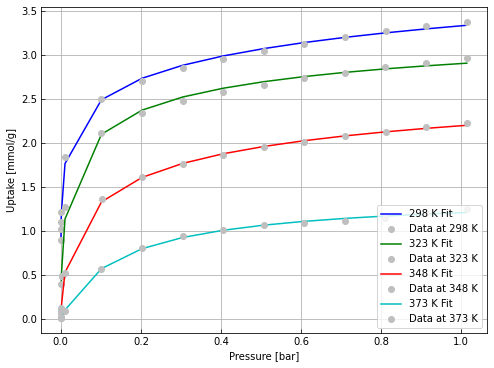

In [17]:
df1 = pd.read_csv('../tests/Datasets for testing/Lewatit CO2.csv')
compname = 'CO2'
temps = [25, 50, 75, 100]
key_pressures = ['p1', 'p2', 'p3', 'p4']
key_uptakes = ['q1', 'q2', 'q3', 'q4']

test = IsothermFit(df1, temps, key_pressures, key_uptakes, "toth", compname)
test.fit()
test.plot(logplot=False)

#### 5.2 Sips fitting




---- Component CO2 fitting results -----


,T (K),q (mmol/g),b (1/bar),n (heterogeneity parameter),MSE
0,263,5.502732,0.391605,1.438557,0.003153
1,303,4.507237,0.166607,1.170366,0.000811
2,343,4.109571,0.069561,1.129936,0.000687


_______________________________________________________________________
Heat of adsorption for site A:-16.1 kJ/mol. 
R sq of Van't Hoff: 0.9966


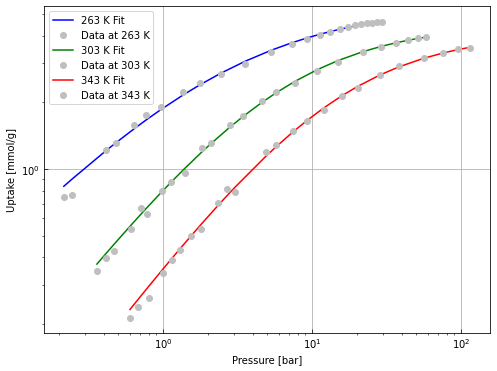

In [18]:
df1 = pd.read_csv('../tests/Datasets for testing/UIO66CO2.csv')
compname = 'CO2'
temps = [263, 303, 343]
key_pressures = ['Pressure1', 'Pressure2', 'Pressure3']
key_uptakes = ['Uptake1', 'Uptake2', 'Uptake3']

test = IsothermFit(df1, temps, key_pressures, key_uptakes, "sips", compname, temp_units='K')
test.fit()
test.plot(logplot=True)

#### 5.3 GAB fitting




---- Component H2O fitting results -----


,T (K),n (mmol/g),ka (H2O activity coeff.),ca (GAB const.),MSE
0,298,5.008542,22.984203,1.466764,0.005244
1,323,2.867165,7.073304,2.952749,0.006126
2,343,2.255719,2.939616,2.805140,0.004551


ΔH_is: 43.4 (∓ 0.44) kJ/mol. 


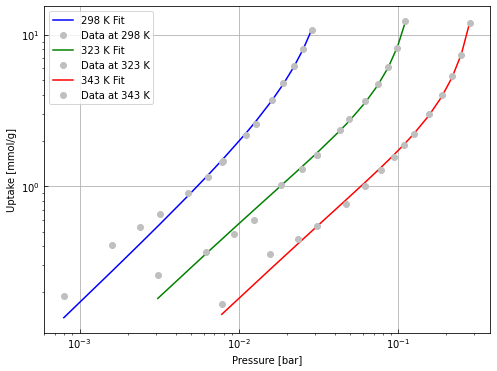

In [19]:
df1 = pd.read_csv('../tests/Datasets for testing/LewatitH₂O.csv')
compname = 'H2O'
temps = [25, 50, 70]
key_pressures = ['Pressure [bar] 25', 'Pressure [bar] 50', 'Pressure [bar] 70']
key_uptakes = ['Loading [mmol/g] 25', 'Loading [mmol/g] 50', 'Loading [mmol/g] 70']

test = IsothermFit(df1, temps, key_pressures, key_uptakes, "gab", compname)
test.fit()
test.plot(logplot=True)

#### 5.4 Henry fitting

The `hen_tol` parameter is useful if you want to manually input the henry regime upper limit for the constrained fitting. To do this input the henry regime upper limits as a list (must be the same length as the amount of datasets inputted)


Henry regime for component CO2:


,Henry constant (mmol/(bar.g)),Upper limit (bar),datapoints,R squared
0,1009.113834,0.0007,5,0.98330
1,161.477952,0.0020,7,0.99707
2,11.306467,0.0007,5,0.99903


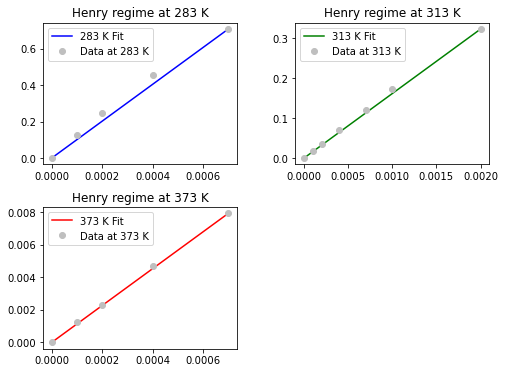

In [20]:
df1 = pd.read_csv('../tests/Datasets for testing/Computational Data (EPFL) CO2.csv')
temps = [10, 40, 100]
key_pressures = ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)']
key_uptakes = ['Uptake (mmol/g)_13X_10 (°C)', 'Uptake (mmol/g)_13X_40 (°C)', 'Uptake (mmol/g)_13X_100 (°C)']

test = IsothermFit(df1, temps, key_pressures, key_uptakes, 'henry', compname='CO2')
test.fit(hen_tol = [0.0008, 0.004, 0.001])
test.plot()

#### 5.5 Linear Langmuir Fitting




---- Component N2 fitting results -----


,T (K),q (mmol/g),b (1/bar),MSE
0,263,3.187632,0.057518,0.116650
1,303,3.472575,0.052972,0.452893
2,343,1.932839,0.038724,1.527213


_______________________________________________________________________
Heat of adsorption for site A:-3.59 kJ/mol. 
R sq of Van't Hoff: 0.9206


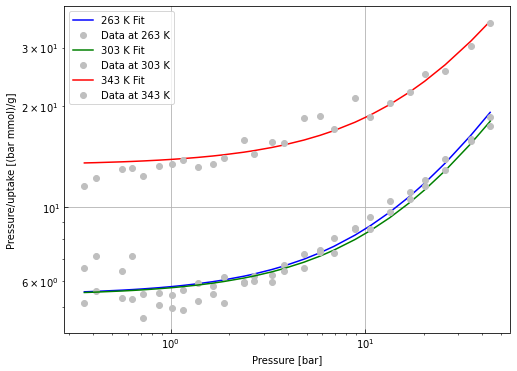

In [21]:
df1 = pd.read_csv('../tests/Datasets for testing/UIO66N2.csv')
compname = 'N2'
temps = [263, 303, 343]
key_pressures = ['Pressure1', 'Pressure2', 'Pressure3']
key_uptakes = ['Uptake1', 'Uptake2', 'Uptake3']

test = IsothermFit(df1, temps, key_pressures, key_uptakes, "langmuir linear 2", compname, temp_units='K')
test.fit()
test.plot(logplot=True)

### 6. Advanced Use Cases
***

The `.fit()` method utilises some of lmfit's flexible functionality to aid with fitting such as setting max and min bounds constraints or setting initial guess values.

Let's say we would like to fita a H₂O on carbon molecular sieve dataset to the Do & Do (`dodo`) isotherm model.





---- Component CO2 fitting results -----


,T (K),ns (mmol/g),kf,nμ (mmol/g),kμ,m,MSE
0,293,33.64768,5.096709,0.004533,0.060046,5.663969,615.747612


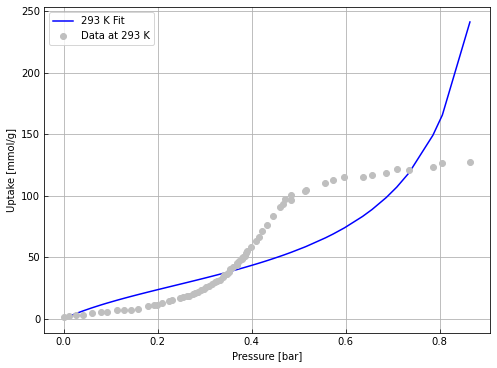

In [22]:
df1 = pd.read_csv('../tests/Datasets for testing/carbonsieve.csv')
temps = [20]
key_pressures = ['p']
key_uptakes = ['q']

test = IsothermFit(df1, temps, key_pressures, key_uptakes, 'dodo', compname='CO2')
test.fit()
test.plot(logplot=False)

Something clearly went wrong with the default bounds or guess values. We can add our own guess values and custom bounds. 

To create custom bounds, create a dictionary of bounds for each parameter - this must be a list of tuples (len = 2) for each parameter. The outer list must be the same length as the number of datasets in the dataframe (for each fitting). The inner bound tuple must be of shape (min, max) for the minimum and maximum bounds. If you don't know/want bounds for one parameter simply input None. 

To add guess values, create another dictionary of the same shape and size, except instead of tuples, list the initial guess values for each dataset fitting. Here we only have one dataset so we only input one.




---- Component CO2 fitting results -----


,T (K),ns (mmol/g),kf,nμ (mmol/g),kμ,m,MSE
0,293,4.334555,956.761775,108.592305,395.353088,6.488206,14.536766


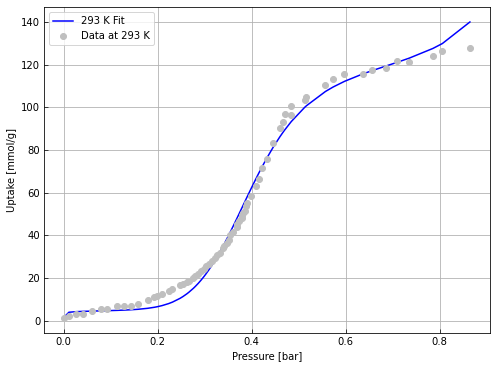

In [23]:
custom_bounds = {
    'ns' : [(0, 100)],
    'kf' : [(0, None)],
    'nu' : [(0, 150)],
    'ku': [(0, None)],
    'm':[(0, 7)]
}

guess = {
    'ns' : [5.0],
    'kf': [600.5545],
    'nu': [105.519855 ],
    'ku': [514.352718],
    'm': [6.75452]
}


test.fit(cust_bounds=custom_bounds, guess=guess)
test.plot(logplot=False)

This is a better fit than before, however it still isnt great - the mean squared error is quite high - it's likely that this model doesn't fit very well to this particular dataset.

The more parameters there are, the more likely it is that the guess and custom bounds kwargs will need to be created and inputted.

We can display a fit report from these fittings if we run this again and set fit_report=True.

In [24]:
test.fit(cust_bounds=custom_bounds, guess=guess, fit_report=True)




---- FIT REPORT FOR DATASET AT 293 K -----
[[Model]]
    Model(dodo)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 71
    # variables        = 5
    chi-square         = 1032.11040
    reduced chi-square = 15.6380364
    Akaike info crit   = 200.044354
    Bayesian info crit = 211.357753
[[Variables]]
    ns:  4.33455489 +/- 0.73496047 (16.96%) (init = 5)
    kf:  956.761775 +/- 3513.95601 (367.28%) (init = 600.5545)
    nu:  108.592305 +/- 3.85798469 (3.55%) (init = 105.5199)
    ku:  395.353088 +/- 153.763145 (38.89%) (init = 514.3527)
    m:   6.48820587 +/- 0.37876341 (5.84%) (init = 6.75452)
[[Correlations]] (unreported correlations are < 0.100)
    C(ku, m)  =  0.995
    C(ns, nu) = -0.914
    C(nu, ku) = -0.849
    C(nu, m)  = -0.836
    C(ns, m)  =  0.726
    C(ns, ku) =  0.717
    C(ns, kf) = -0.231
    C(kf, nu) =  0.200
    C(kf, ku) = -0.147
    C(kf, m)  = -0.144



---- Component CO2 fitting results -----


,T (K),ns (mmol/g),kf,nμ (mmol/g),kμ,m,MSE
0,293,4.334555,956.761775,108.592305,395.353088,6.488206,14.536766


#### 6.1 MDR Fitting
***

For the `logplot`, we can set the x axis to logplot but not for y by entering a tuple in the form `(x(logplot), y(logplot))`




---- Component CO2 fitting results -----


,T (K),n0,n1,a,c,MSE
0,283,7.032528,1000.000000,9065.110823,0.019054,0.008000
1,313,6.402433,708.894626,1190.300411,0.032242,0.005212
2,373,5.087375,92.121222,27.517905,0.128388,0.003468


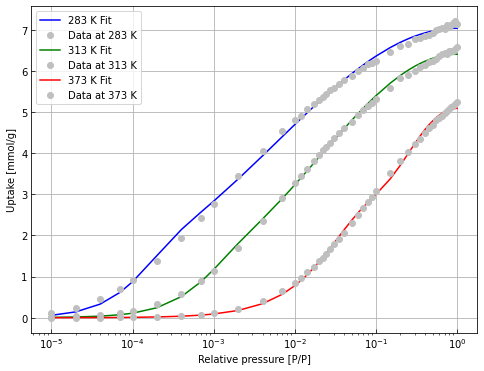

In [25]:
df1 = pd.read_csv('../tests/Datasets for testing/Computational Data (EPFL) CO2.csv')
temps = [10, 40, 100]
key_pressures = ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)']
key_uptakes = ['Uptake (mmol/g)_13X_10 (°C)', 'Uptake (mmol/g)_13X_40 (°C)', 'Uptake (mmol/g)_13X_100 (°C)']

test = IsothermFit(df1, temps, key_pressures, key_uptakes, 'mdr', compname='CO2')
cust_bounds =  {
    'n0': [(0, None), (3, None), (3,7)],
    'n1': [(1000, None), (0, None), (0, None)],
    'a': [(0, None), (0, None), (0, None)],
    'c': [(0, 1), (0, 2), (0, 1)]
}
test.fit(cust_bounds=cust_bounds)
test.plot(logplot=(True, False))